# Path to an Augmented Dataset - How to get our data into Dask?

## Problem

SQL -> Dask

1 Month of data ~ 100 GB (denomalized, uncompressed)

Ideal size of a pod at about 8GB (sweat spot in our cluster)

If accounting for some room for actual compute, this leaves us with a few hundred MBs of data per partition

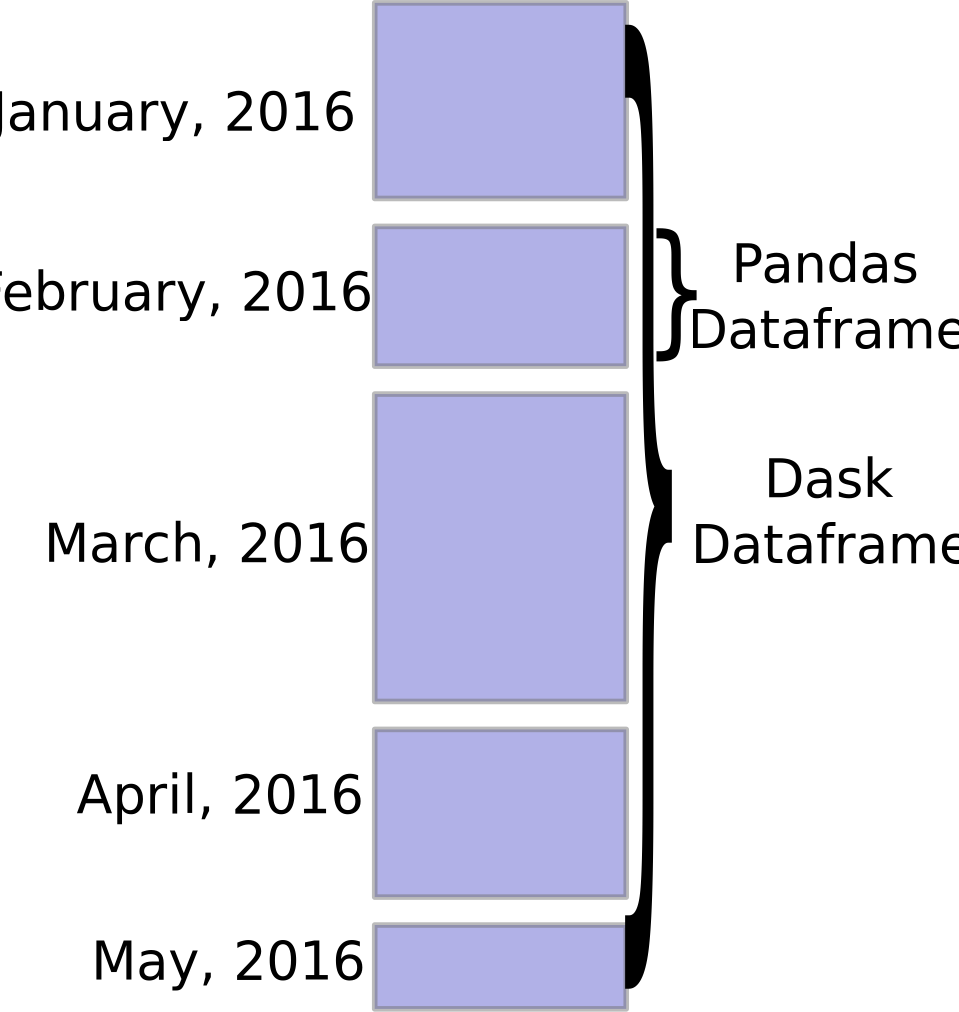

In [1]:
from IPython.display import Image 
Image("dask-dataframe.png", width=500)

## We'll follow "Dataframe SQL / Load from SQL manual approaches"

https://docs.dask.org/en/latest/dataframe-sql.html#load-from-sql-manual-approaches

In [2]:
from dask import delayed
import dask.dataframe as dd

@delayed
def fetch_partition(part):
    conn = establish_connection()
    df = fetch_query(base_query.format(part))
    return df.astype(known_types)

ddf = dd.from_delayed([fetch_partition(part) for part in parts],
                       meta=known_types,
                       divisions=div_from_parts(parts))

NameError: name 'parts' is not defined

### Ingredients
1. Connection
2. SQL / Query
3. ~Schema~ (Depends on 2.)
4. *Partitions*
5. Avoid killing your database

# 1. Fast connect using turbodbc

https://github.com/blue-yonder/turbodbc


Easier interface using pandas, see

https://github.com/pandas-dev/pandas/issues/17790

https://github.com/pandas-dev/pandas/issues/36893

In [3]:
import turbodbc
from contextlib import closing


def fetch_partition_turbodbc(query, connection_params):
    options = turbodbc.make_options(
        large_decimals_as_64_bit_types=True,
        read_buffer_size=turbodbc.Megabytes(256),
        autocommit=False,
    )
    with closing(
        turbodbc.connect(
            query,
            connection_params,
            turbodbc_options=options,
        )
    ) as conn:
        with closing(conn.cursor()) as cursor:
            cursor.execute(query)
            table = cursor.fetchallarrow(strings_as_dictionary=True)
    return table.to_pandas()

# 2. SQL Query

In [4]:
def get_query(date_start, partition_id, days_in_chunk=7):
    return f"""
    SELECT *
    FROM 
        super_complicated_query
    WHERE
        date >= {date_start} AND
        date <= {date_start} + {days_in_chunk} AND
        partition={partition_id}
    """

# How to get my "partition_id"?

## Let's split the data using a bit of business logic

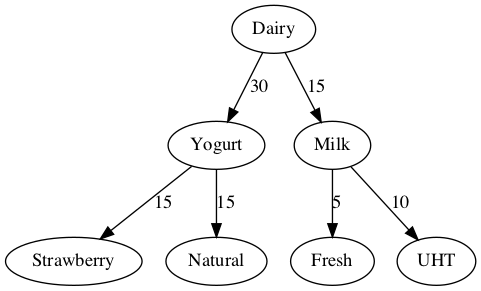

In [5]:
from graphviz import Digraph


g = Digraph(comment='Productgroups')

g.node("Dairy")
g.node("Yogurt")
g.node("Milk")
g.node("Strawberry")
g.node("Natural")
g.node("Fresh")
g.node("UHT")


g.edge("Dairy", "Yogurt", label="30")
g.edge("Yogurt", "Strawberry", label="15")
g.edge("Yogurt", "Natural", label="15")
g.edge("Dairy", "Milk", label="15")
g.edge("Milk", "Fresh", label="5")
g.edge("Milk", "UHT", label="10")

import IPython.display as display
display.Image(g.render(format='png'))

In [4]:
import pandas as pd
partition_mapping = pd.DataFrame({
    "product_group_1": "Dairy",
    "product_group_2": ["Yogurt"] * 2 + ["Milk"] * 2,
    "product_group_3": ["Strawberry", "Natural", "Fresh", "UHT"],
    "partition_id": [0, 1, 2, 2]
})
partition_mapping

,product_group_1,product_group_2,product_group_3,partition_id
0,Dairy,Yogurt,Strawberry,0
1,Dairy,Yogurt,Natural,1
2,Dairy,Milk,Fresh,2
3,Dairy,Milk,UHT,2


In [1]:
from distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:61458 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [6]:
import pandas as pd
import numpy as np

def fetch_partition_fake(
    partition_id: int,
    n_dates: int=7,
    n_products: int=5,
    n_locations: int=5,
    date_start= "2018-01-01",
) -> pd.DataFrame:
    import itertools

    payload_columns = [
        "sales",
        "prices",
        "stocks",
    ]
    def locations_generator(n):
        return [f"L-{x}" for x in range(n)]
    def products_generator(n):
        return [f"P-{x}" for x in range(n)]
    date_range = pd.date_range(date_start, periods=n_dates)

    locations = list(
        zip(locations_generator(n_locations), range(1000, n_locations + 1000))
    )

    products = range(partition_id * 100, n_products + partition_id * 100)

    locations = range(n_locations)
    JOIN_COL = "__JOIN_FAKES___"
    df_locs = pd.DataFrame({"location": locations, JOIN_COL: 1})
    df_dates = pd.DataFrame({"date": date_range, JOIN_COL: 1})
    df_prods = pd.DataFrame({"product": products, JOIN_COL: 1})
    pgs = partition_mapping[partition_mapping.partition_id == (partition_id % partition_mapping.partition_id.nunique())]
    pg3s = np.tile(pgs.product_group_3.values, len(df_prods))[:len(df_prods)]
    np.random.shuffle(pg3s)
    df_prods["product_group_3"] = pg3s
    df_prods = df_prods.merge(pgs)
    full_dimension = (
        df_locs.merge(df_prods)
        .merge(df_dates)
        .drop(JOIN_COL, axis=1)
        .reset_index(drop=True)
    )
    for col in payload_columns:
        full_dimension[col] = np.random.rand(len(full_dimension))
    column_ordering = [
        "date", 
        "product", 
        "location", 
        "partition_id", 
        "product_group_1", 
        "product_group_2", 
        "product_group_3"
    ] + payload_columns
    return full_dimension[column_ordering]
res = fetch_partition_fake(
    partition_id=2,
    n_dates=7,
    date_start="2020-01-01"
)
schema = res
res

,date,product,location,partition_id,product_group_1,product_group_2,product_group_3,sales,prices,stocks
0,2020-01-01,200,0,2,Dairy,Milk,UHT,0.634356,0.657599,0.251657
1,2020-01-02,200,0,2,Dairy,Milk,UHT,0.535180,0.301707,0.438172
2,2020-01-03,200,0,2,Dairy,Milk,UHT,0.179077,0.776689,0.046874
3,2020-01-04,200,0,2,Dairy,Milk,UHT,0.805611,0.745109,0.418958
4,2020-01-05,200,0,2,Dairy,Milk,UHT,0.797960,0.088373,0.620383
...,...,...,...,...,...,...,...,...,...,...
170,2020-01-03,204,4,2,Dairy,Milk,Fresh,0.056045,0.463344,0.268613
171,2020-01-04,204,4,2,Dairy,Milk,Fresh,0.635755,0.724610,0.251632
172,2020-01-05,204,4,2,Dairy,Milk,Fresh,0.398882,0.794076,0.645206
173,2020-01-06,204,4,2,Dairy,Milk,Fresh,0.341030,0.931086,0.037898


## What's left to do is to specify how much data to download and hit the database

In [7]:
import pandas as pd
import itertools

# imagine a webservice with a simple REST API accepting the following parameters...

date_start = pd.Timestamp("2020-01-01")
n_weeks = 4
n_clusters = 3

In [8]:
import pandas as pd
def get_job_list(start, n_weeks, n_clusters):
    week_starts = list(pd.date_range(start, freq="7D", periods=n_weeks))
    return list(itertools.product(week_starts, range(n_clusters)))
get_job_list("2020-01-01", 2, 2)

[(Timestamp('2020-01-01 00:00:00', freq='7D'), 0),
 (Timestamp('2020-01-01 00:00:00', freq='7D'), 1),
 (Timestamp('2020-01-08 00:00:00', freq='7D'), 0),
 (Timestamp('2020-01-08 00:00:00', freq='7D'), 1)]

# 5. How not to kill the database?

In [9]:
from distributed import Semaphore
sem = Semaphore(max_leases=2, name='database')

In [13]:
import dask
import distributed

@dask.delayed
def download_one_week_from_db(sem: distributed.Semaphore, start: pd.Timestamp, partition_id: int):
    with sem:
        import time
        time.sleep(0.5)
        # Connect to DB. Here we're using fake data
        return fetch_partition_fake(date_start=start, partition_id=partition_id)

In [14]:
import dask.dataframe as dd

def get_dask_dataframe(date_start, n_weeks, n_clusters):
    
    jobs = [
        download_one_week_from_db(sem, part_start, cluster)
        for part_start, cluster in get_job_list(date_start, n_weeks, n_clusters)
    ]
    return dd.from_delayed(jobs, meta=schema)

ddf = get_dask_dataframe("2020-01-01", 4, 3)
ddf

,date,product,location,partition_id,product_group_1,product_group_2,product_group_3,sales,prices,stocks
npartitions=12,,,,,,,,,,
,datetime64[ns],int64,int64,int64,object,object,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


In [16]:
def post_processing(ddf):
    ddf["week"] = ddf['date'].dt.isocalendar().week
    
    ddf["QualityCheckA"] = ddf['sales'] >= 0
    
    ddf['sales_normalized'] = ddf['sales'].where(ddf['sales'] >= 0, 0)
    
    ddf['featureA'] = ddf['sales'] ** 2
    ddf['featureB'] = ddf['sales'] - ddf['stocks']
    
    return ddf

ddf_final = post_processing(ddf)
ddf_final

,date,product,location,partition_id,product_group_1,product_group_2,product_group_3,sales,prices,stocks,week,QualityCheckA,sales_normalized,featureA,featureB
npartitions=12,,,,,,,,,,,,,,,
,datetime64[ns],int64,int64,int64,object,object,object,float64,float64,float64,UInt32,bool,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [17]:
ddf_final.head()

,date,product,location,partition_id,product_group_1,product_group_2,product_group_3,sales,prices,stocks,week,QualityCheckA,sales_normalized,featureA,featureB
0,2020-01-01,0,0,0,Dairy,Yogurt,Strawberry,0.022368,0.796000,0.487135,1,True,0.022368,0.000500,-0.464767
1,2020-01-02,0,0,0,Dairy,Yogurt,Strawberry,0.552396,0.369790,0.632808,1,True,0.552396,0.305141,-0.080412
2,2020-01-03,0,0,0,Dairy,Yogurt,Strawberry,0.856132,0.900622,0.914506,1,True,0.856132,0.732962,-0.058374
3,2020-01-04,0,0,0,Dairy,Yogurt,Strawberry,0.380664,0.711724,0.646026,1,True,0.380664,0.144905,-0.265362
4,2020-01-05,0,0,0,Dairy,Yogurt,Strawberry,0.077032,0.255194,0.861011,1,True,0.077032,0.005934,-0.783980


In [18]:
%%time
ddf_final.sales.sum().compute()

CPU times: user 289 ms, sys: 29.9 ms, total: 319 ms
Wall time: 3.31 s


1056.5994756191446

In [19]:
ddf_final

,date,product,location,partition_id,product_group_1,product_group_2,product_group_3,sales,prices,stocks,week,QualityCheckA,sales_normalized,featureA,featureB
npartitions=12,,,,,,,,,,,,,,,
,datetime64[ns],int64,int64,int64,object,object,object,float64,float64,float64,UInt32,bool,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# Persist data as a parquet dataset using kartothek

Reasons why one wants to persist this intermediate data

* Resilience
* Consistency (e.g. data may change an hour later)
* Data lineage (What data was used for my model training, etc.0


* https://github.com/JDASoftwareGroup/kartothek  
* https://kartothek.readthedocs.io/en/latest/

In [19]:
from kartothek.core.utils import ensure_store

store_url = 'hfs://coiled_demo'
store = ensure_store(store_url)
for k in store:
    store.delete(k)

In [20]:
from kartothek.io.dask.dataframe import store_dataset_from_ddf
from kartothek.io.dask.dataframe_cube import build_cube_from_dataframe

dataset_uuid = "augmented_dataset"
augmented_dataset = store_dataset_from_ddf(
    # These three are required
    ddf,
    dataset_uuid=dataset_uuid,
    store=store_url,
    
    # The following control the physical attributes of the dataset
    partition_on=[
        "week",
        "partition_id",
    ],
    secondary_indices=[
        "date",
        "product_group_1",
        "product_group_2",
        "product_group_3",
    ],
    
    # By default, kartothek disallows mutation. Since we're in a demo here...
    overwrite=True,
).compute()
augmented_dataset

DatasetMetadata(uuid=augmented_dataset, tables=['table'], partition_keys=['week', 'partition_id'], metadata_version=4, indices=['date', 'product_group_1', 'product_group_2', 'product_group_3'], explicit_partitions=True)

In [21]:
sorted(store.keys())

['augmented_dataset.by-dataset-metadata.json',
 'augmented_dataset/indices/date/2020-11-05T12%3A41%3A59.899784.by-dataset-index.parquet',
 'augmented_dataset/indices/product_group_1/2020-11-05T12%3A41%3A59.899842.by-dataset-index.parquet',
 'augmented_dataset/indices/product_group_2/2020-11-05T12%3A41%3A59.899901.by-dataset-index.parquet',
 'augmented_dataset/indices/product_group_3/2020-11-05T12%3A41%3A59.899955.by-dataset-index.parquet',
 'augmented_dataset/table/_common_metadata',
 'augmented_dataset/table/week=1/partition_id=0/37a8abe7a30547b39a8ab941ce99217e.parquet',
 'augmented_dataset/table/week=1/partition_id=1/5640750bc8664db999c168122d1d82da.parquet',
 'augmented_dataset/table/week=1/partition_id=2/2ae6e295e32241b78bf983c7009778b5.parquet',
 'augmented_dataset/table/week=2/partition_id=0/28af32ca1b574656afeb57f1af96ac25.parquet',
 'augmented_dataset/table/week=2/partition_id=0/37a8abe7a30547b39a8ab941ce99217e.parquet',
 'augmented_dataset/table/week=2/partition_id=1/5640750b

In [23]:
augmented_dataset

DatasetMetadata(uuid=augmented_dataset, tables=['table'], partition_keys=['week', 'partition_id'], metadata_version=4, indices=['date', 'product_group_1', 'product_group_2', 'product_group_3'], explicit_partitions=True)

In [25]:
sorted(augmented_dataset.partitions.keys())

['week=1/partition_id=0/37a8abe7a30547b39a8ab941ce99217e',
 'week=1/partition_id=1/5640750bc8664db999c168122d1d82da',
 'week=1/partition_id=2/2ae6e295e32241b78bf983c7009778b5',
 'week=2/partition_id=0/28af32ca1b574656afeb57f1af96ac25',
 'week=2/partition_id=0/37a8abe7a30547b39a8ab941ce99217e',
 'week=2/partition_id=1/5640750bc8664db999c168122d1d82da',
 'week=2/partition_id=1/f60b13745f3c461780b636b96ed56285',
 'week=2/partition_id=2/2ae6e295e32241b78bf983c7009778b5',
 'week=2/partition_id=2/6d595bd829ac4a788f54cf7c46613dab',
 'week=3/partition_id=0/28af32ca1b574656afeb57f1af96ac25',
 'week=3/partition_id=0/2b66a0be0f644708a3b9f7207e02fdf9',
 'week=3/partition_id=1/a83f3cf6599845abb0e95034bb523c8e',
 'week=3/partition_id=1/f60b13745f3c461780b636b96ed56285',
 'week=3/partition_id=2/451e11e9e16d4fb8beb0a994e9032f4e',
 'week=3/partition_id=2/6d595bd829ac4a788f54cf7c46613dab',
 'week=4/partition_id=0/2b66a0be0f644708a3b9f7207e02fdf9',
 'week=4/partition_id=0/878f6fc56e6e460b8e60095e203ac2df

In [24]:
augmented_dataset.table_meta['table']

week: uint64
  -- field metadata --
  PARQUET:field_id: '1'
partition_id: int64
  -- field metadata --
  PARQUET:field_id: '2'
QualityCheckA: bool
  -- field metadata --
  PARQUET:field_id: '3'
date: timestamp[ns]
featureA: double
  -- field metadata --
  PARQUET:field_id: '5'
featureB: double
  -- field metadata --
  PARQUET:field_id: '6'
location: int64
  -- field metadata --
  PARQUET:field_id: '7'
prices: double
  -- field metadata --
  PARQUET:field_id: '8'
product: int64
  -- field metadata --
  PARQUET:field_id: '9'
product_group_1: string
  -- field metadata --
  PARQUET:field_id: '10'
product_group_2: string
  -- field metadata --
  PARQUET:field_id: '11'
product_group_3: string
  -- field metadata --
  PARQUET:field_id: '12'
sales: double
  -- field metadata --
  PARQUET:field_id: '13'
sales_normalized: double
  -- field metadata --
  PARQUET:field_id: '14'
stocks: double
  -- field metadata --
  PARQUET:field_id: '15'
-- schema metadata --
pandas: '{"column_indexes": [{"fiel

In [26]:
dask_ddf = dd.read_parquet("coiled_demo/augmented_dataset/table/**")
dask_ddf

,week,partition_id,QualityCheckA,date,featureA,featureB,location,prices,product,product_group_1,product_group_2,product_group_3,sales,sales_normalized,stocks
npartitions=25,,,,,,,,,,,,,,,
,uint64,int64,bool,datetime64[ns],float64,float64,int64,float64,int64,object,object,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [27]:
dask_ddf["sales"].sum().compute()

1060.779795833835

In [28]:
from kartothek.io.dask.dataframe import read_dataset_as_ddf
kartothek_ddf = read_dataset_as_ddf(
    dataset_uuid=dataset_uuid,
    store=store,
)
kartothek_ddf

,week,partition_id,QualityCheckA,date,featureA,featureB,location,prices,product,product_group_1,product_group_2,product_group_3,sales,sales_normalized,stocks
npartitions=24,,,,,,,,,,,,,,,
,uint64,int64,bool,datetime64[ns],float64,float64,int64,float64,int64,object,object,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [29]:
kartothek_ddf.sales.sum().compute()

1060.7797958338347

In [30]:
augmented_dataset = augmented_dataset.load_all_indices(store)
sorted(augmented_dataset.indices)

['date',
 'partition_id',
 'product_group_1',
 'product_group_2',
 'product_group_3',
 'week']

In [32]:
# No partition pruning
ddf_s0 = read_dataset_as_ddf(
    dataset_uuid=dataset_uuid,
    store=store,
    predicates=[[
        ("sales", ">=", 0.5),
    ]]
)
ddf_s0

,week,partition_id,QualityCheckA,date,featureA,featureB,location,prices,product,product_group_1,product_group_2,product_group_3,sales,sales_normalized,stocks
npartitions=24,,,,,,,,,,,,,,,
,uint64,int64,bool,datetime64[ns],float64,float64,int64,float64,int64,object,object,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [34]:
sum_s0 = ddf_s0.sales.sum()

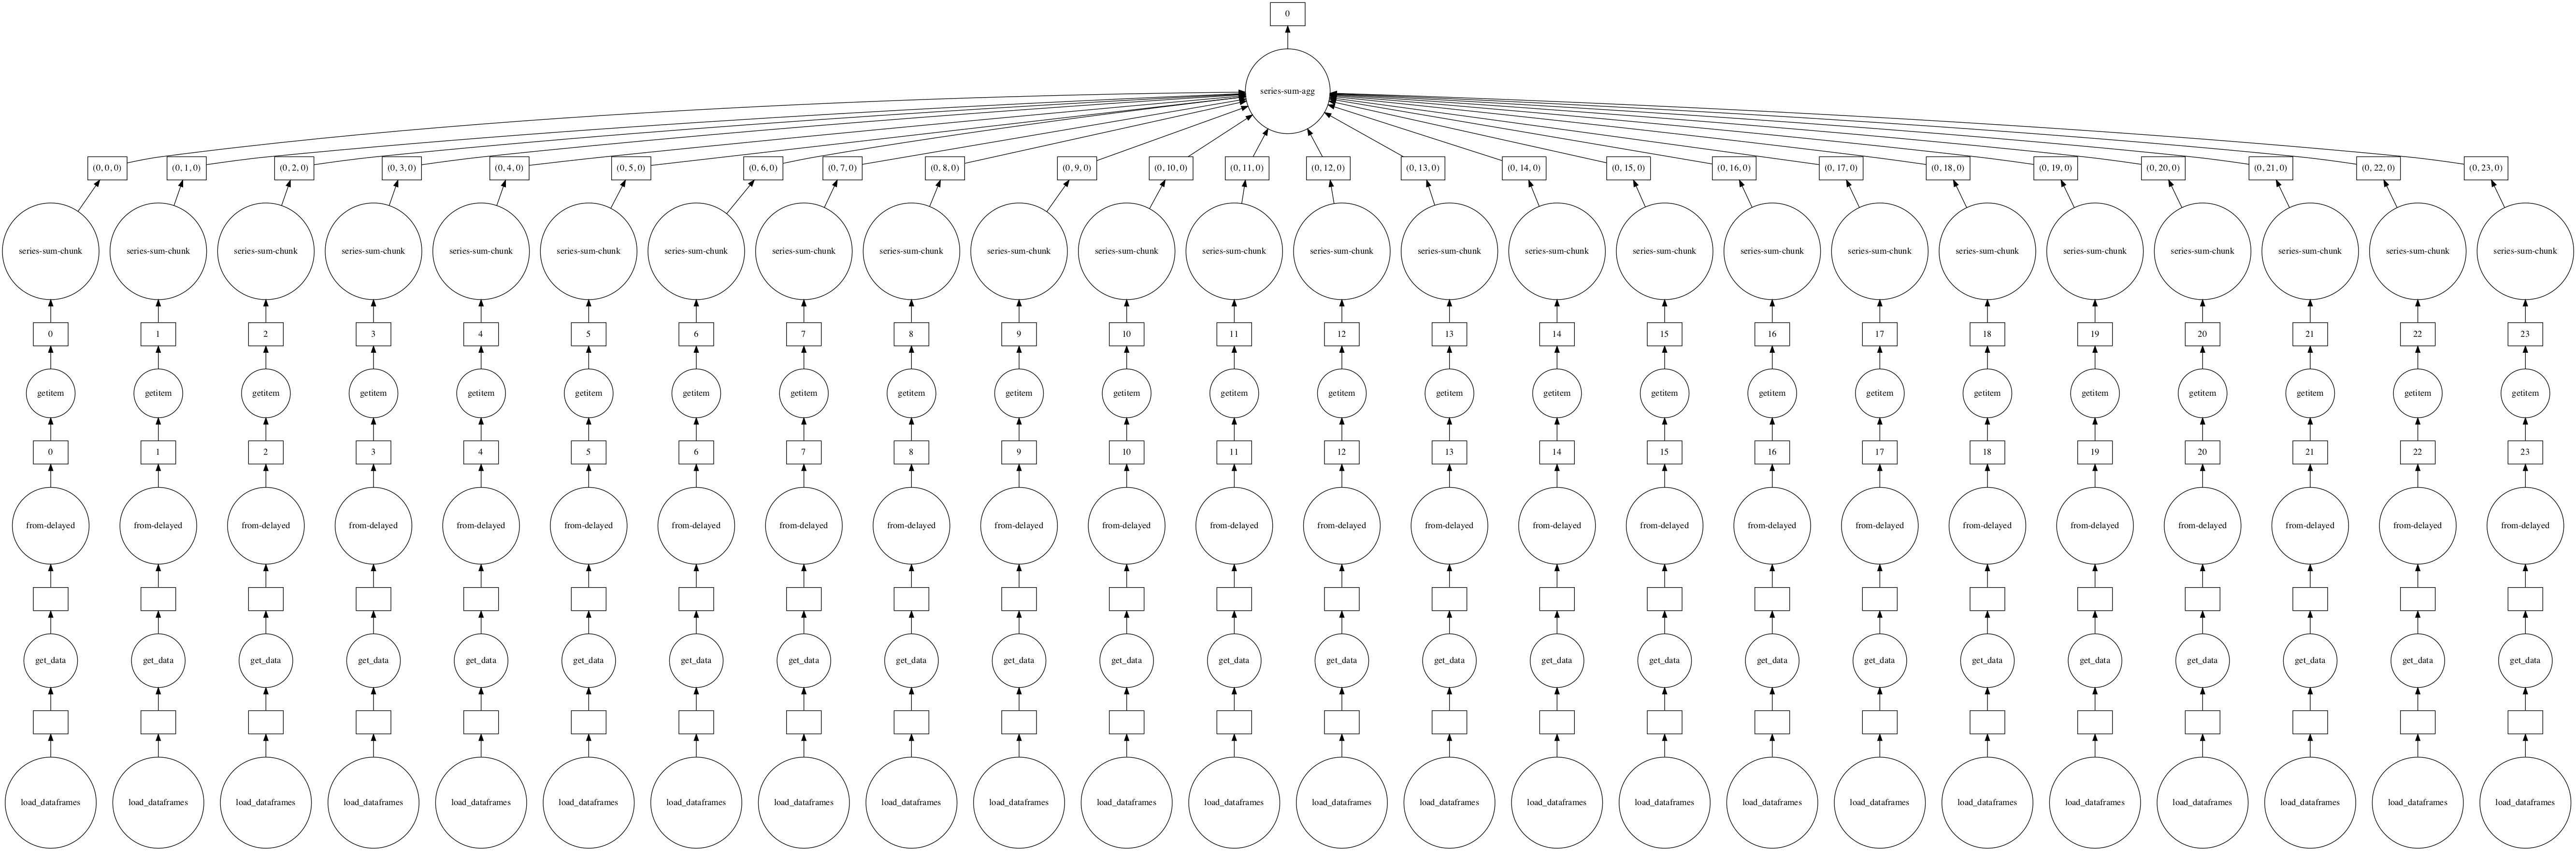

In [35]:
sum_s0.visualize()

In [36]:
# Partition pruning using partition keys / information encoded in the file names
ddf_p0 = read_dataset_as_ddf(
    dataset_uuid=dataset_uuid,
    store=store,
    predicates=[[
        ("sales", ">=", 0.5),
        ("week", "==", 1),
    ]]
)
ddf_p0

,week,partition_id,QualityCheckA,date,featureA,featureB,location,prices,product,product_group_1,product_group_2,product_group_3,sales,sales_normalized,stocks
npartitions=3,,,,,,,,,,,,,,,
,uint64,int64,bool,datetime64[ns],float64,float64,int64,float64,int64,object,object,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [37]:
sales_p0 = ddf_p0.sales.sum()

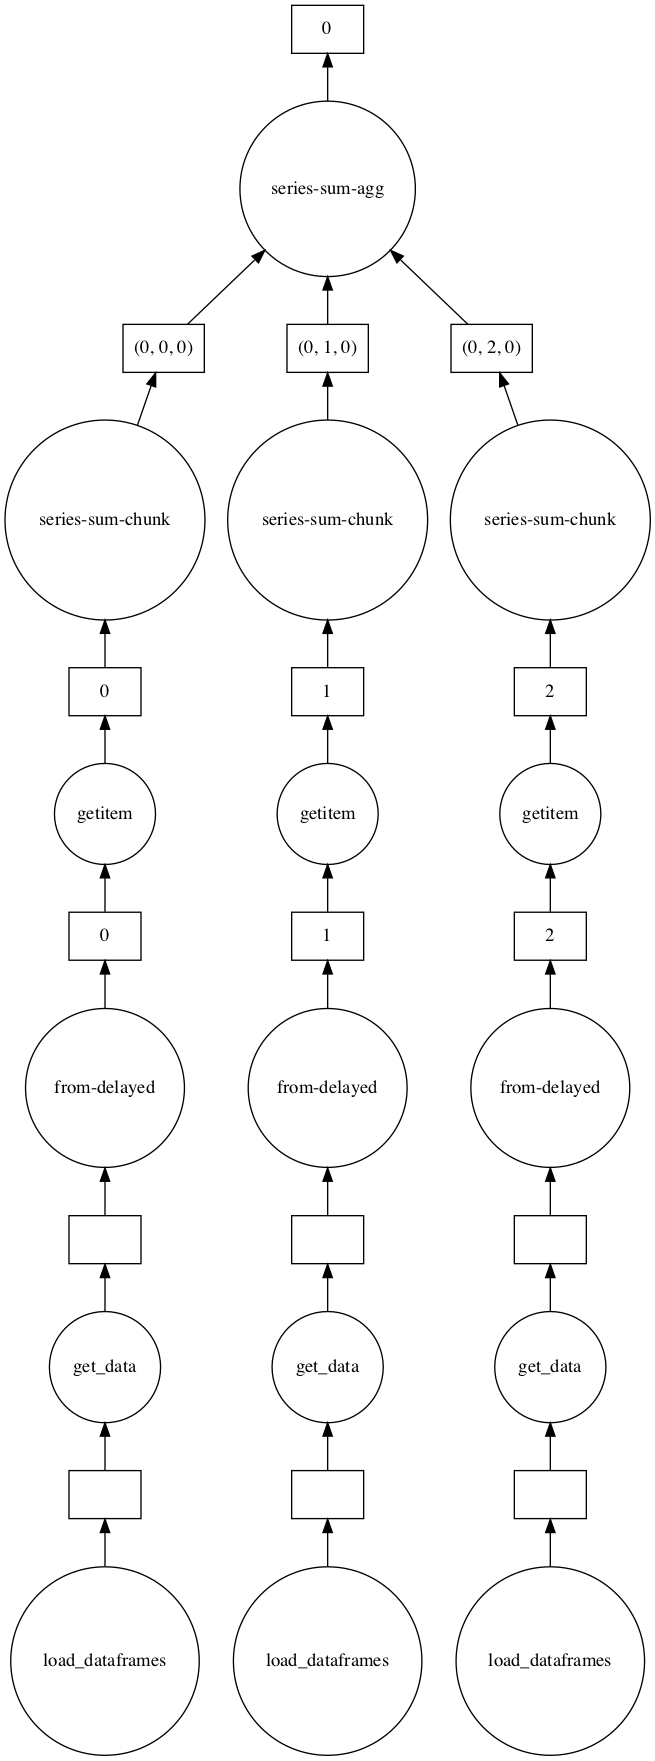

In [38]:
sales_p0.visualize()

In [39]:
sorted([ k for k in store.keys() if "week=1" in k])

['augmented_dataset/table/week=1/partition_id=0/37a8abe7a30547b39a8ab941ce99217e.parquet',
 'augmented_dataset/table/week=1/partition_id=1/5640750bc8664db999c168122d1d82da.parquet',
 'augmented_dataset/table/week=1/partition_id=2/2ae6e295e32241b78bf983c7009778b5.parquet']

In [40]:
# "Hidden partitioning" by using secondary indices, users do not really need to bother with the physical layout

ddf_pg = read_dataset_as_ddf(
    dataset_uuid=dataset_uuid,
    store=store,
    predicates=[[
        ("sales", ">=", 0.5),
        ("week", "==", 1),
        ("product_group_2", "==", "Milk"),
    ]]
)
ddf_pg

,week,partition_id,QualityCheckA,date,featureA,featureB,location,prices,product,product_group_1,product_group_2,product_group_3,sales,sales_normalized,stocks
npartitions=1,,,,,,,,,,,,,,,
,uint64,int64,bool,datetime64[ns],float64,float64,int64,float64,int64,object,object,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [41]:
sales_pg = ddf_pg.sales.sum()

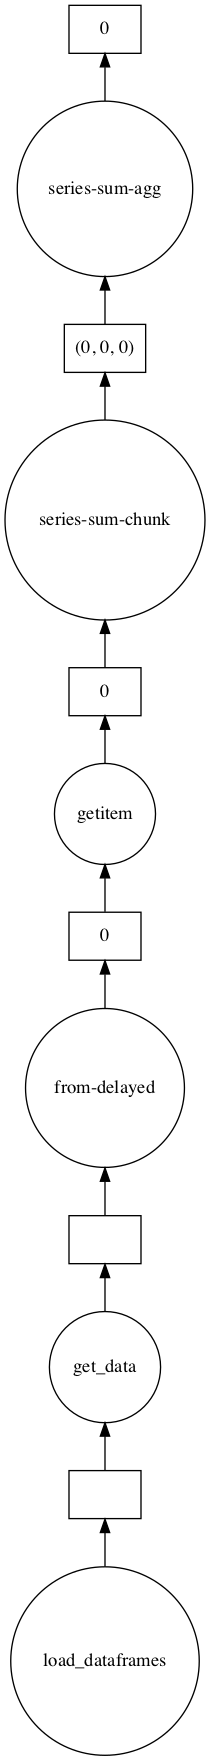

In [42]:
sales_pg.visualize()

In [68]:
augmented_dataset.indices['product_group_2'].observed_values()

array(['Yogurt', 'Milk'], dtype=object)

In [69]:
augmented_dataset.get_indices_as_dataframe()

,partition_id,product_group_1,product_group_2,week,product_group_3,date
partition,,,,,,
week=1/partition_id=0/a18350223f3e488eb6e49cd5079f8bf0,0,Dairy,Yogurt,1,Strawberry,2020-01-01
week=1/partition_id=0/a18350223f3e488eb6e49cd5079f8bf0,0,Dairy,Yogurt,1,Strawberry,2020-01-02
week=1/partition_id=0/a18350223f3e488eb6e49cd5079f8bf0,0,Dairy,Yogurt,1,Strawberry,2020-01-05
week=1/partition_id=0/a18350223f3e488eb6e49cd5079f8bf0,0,Dairy,Yogurt,1,Strawberry,2020-01-04
week=1/partition_id=0/a18350223f3e488eb6e49cd5079f8bf0,0,Dairy,Yogurt,1,Strawberry,2020-01-03
...,...,...,...,...,...,...
week=5/partition_id=1/47e656adefbe4f5a83cd2913ab6a1185,1,Dairy,Yogurt,5,Natural,2020-01-28
week=5/partition_id=2/dd51d3aacae34e2ead815a5b12366ff0,2,Dairy,Milk,5,UHT,2020-01-27
week=5/partition_id=2/dd51d3aacae34e2ead815a5b12366ff0,2,Dairy,Milk,5,UHT,2020-01-28


# How to get 10 years of data into this dataset?

In [43]:
max(augmented_dataset.indices['date'].observed_values())

numpy.datetime64('2020-01-28T00:00:00.000000000')

In [44]:
import datetime
new_start = datetime.date(2020, 1, 29)

In [45]:
new_data = get_dask_dataframe(new_start, 4, 3)

In [46]:
new_data.date.max().compute()

Timestamp('2020-02-25 00:00:00')

In [47]:
from kartothek.io.dask.dataframe import update_dataset_from_ddf

update_graph = update_dataset_from_ddf(
    post_processing(new_data),
    store=store,
    dataset_uuid=augmented_dataset.uuid,

    # There is a bug, how embarassing. Usually we don't need to specify this
    secondary_indices=sorted(augmented_dataset.secondary_indices.keys()),
)
update_graph

Delayed('update_dataset_from_partitions-372d95bc-abf1-4848-b6a5-66eb0f1669e3')

In [48]:
new_ds = update_graph.compute()
new_ds

DatasetMetadata(uuid=augmented_dataset, tables=['table'], partition_keys=['week', 'partition_id'], metadata_version=4, indices=['date', 'product_group_1', 'product_group_2', 'product_group_3'], explicit_partitions=True)

In [49]:
new_data.date.max().compute()

Timestamp('2020-02-25 00:00:00')

In [50]:
new_ds = new_ds.load_all_indices(store)
max(new_ds.indices['date'].observed_values())

numpy.datetime64('2020-02-25T00:00:00.000000000')

In [51]:
indices_augmented = new_ds.get_indices_as_dataframe()
indices_augmented

,partition_id,product_group_1,product_group_2,week,product_group_3,date
partition,,,,,,
week=1/partition_id=0/37a8abe7a30547b39a8ab941ce99217e,0,Dairy,Yogurt,1,Strawberry,2020-01-01
week=1/partition_id=0/37a8abe7a30547b39a8ab941ce99217e,0,Dairy,Yogurt,1,Strawberry,2020-01-02
week=1/partition_id=0/37a8abe7a30547b39a8ab941ce99217e,0,Dairy,Yogurt,1,Strawberry,2020-01-05
week=1/partition_id=0/37a8abe7a30547b39a8ab941ce99217e,0,Dairy,Yogurt,1,Strawberry,2020-01-04
week=1/partition_id=0/37a8abe7a30547b39a8ab941ce99217e,0,Dairy,Yogurt,1,Strawberry,2020-01-03
...,...,...,...,...,...,...
week=9/partition_id=1/bcdadf7c27564f4f99c70f93f19dc89a,1,Dairy,Yogurt,9,Natural,2020-02-25
week=9/partition_id=2/b5ba40580caa4ecd9888f973f875efdc,2,Dairy,Milk,9,Fresh,2020-02-24
week=9/partition_id=2/b5ba40580caa4ecd9888f973f875efdc,2,Dairy,Milk,9,Fresh,2020-02-25


# Where is the Machine Learning?!

In [53]:
ddf = read_dataset_as_ddf(
    store=store,
    dataset_uuid=augmented_dataset.uuid,
    dispatch_by="partition_id",
)

In [54]:
def generate_predictions(partition):
    # Load ML expert / pre trained model
    import time
    time.sleep(1)
    predictions = partition[["date", "location", "product", "partition_id"]]
    return predictions.assign(
        predictions=np.random.rand(len(partition)),
        prediction_timestamp=time.time(),
        classifier=(partition.partition_id % 2).astype(bool),
    )

In [55]:
predictions = ddf.map_partitions(generate_predictions)
predictions.compute()

,date,location,product,partition_id,predictions,prediction_timestamp,classifier
0,2020-01-08,0,0,0,0.799630,1.604581e+09,False
1,2020-01-09,0,0,0,0.183369,1.604581e+09,False
2,2020-01-10,0,0,0,0.736970,1.604581e+09,False
3,2020-01-11,0,0,0,0.622748,1.604581e+09,False
4,2020-01-12,0,0,0,0.344178,1.604581e+09,False
...,...,...,...,...,...,...,...
120,2020-01-29,4,203,2,0.320300,1.604581e+09,False
121,2020-01-30,4,203,2,0.734292,1.604581e+09,False
122,2020-01-31,4,203,2,0.701188,1.604581e+09,False
123,2020-02-01,4,203,2,0.636086,1.604581e+09,False


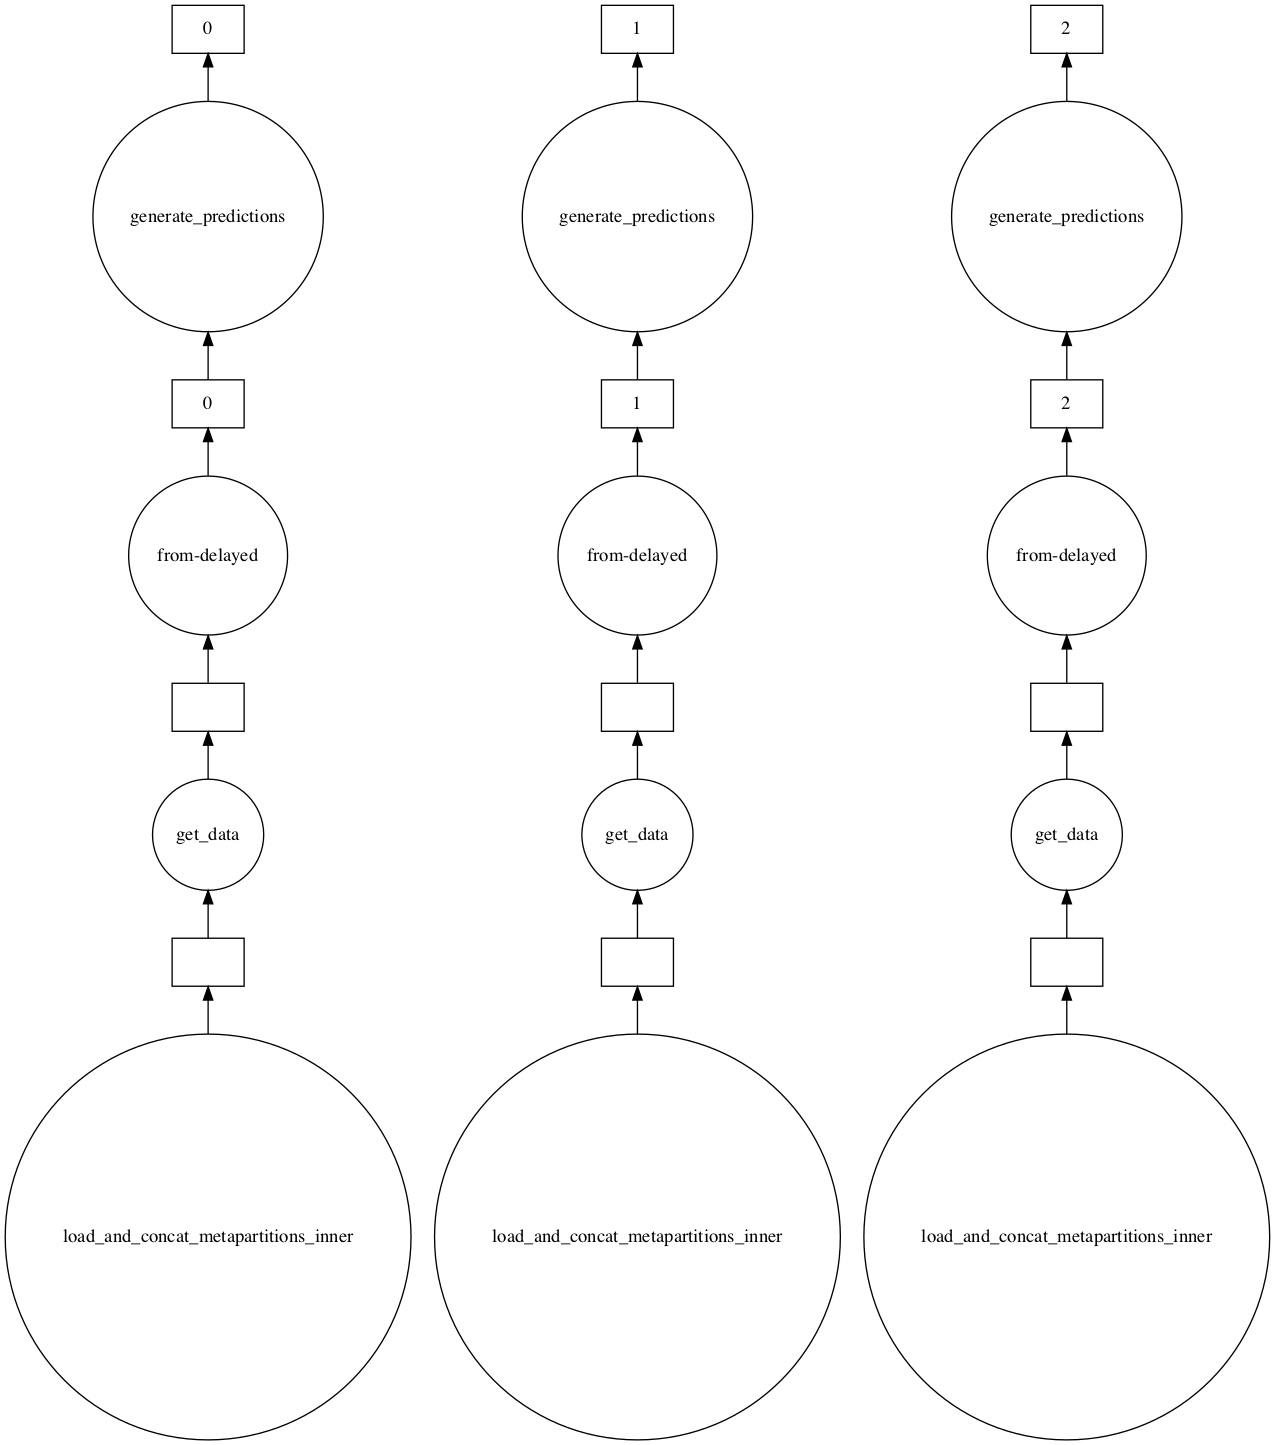

In [86]:
predictions.visualize()

In [58]:
pred_dataset = store_dataset_from_ddf(
    predictions,
    dataset_uuid="predictions",
    store=store,
    partition_on='partition_id',
    secondary_indices=[
        "location",
        "product",
        "classifier",
    ],
    overwrite=True,
).compute()

In [59]:
pred_dataset = pred_dataset.load_all_indices(store)
indices_prediction = pred_dataset.get_indices_as_dataframe()
indices_prediction

,classifier,partition_id,location,product
partition,,,,
partition_id=0/8b016dc687d642ba9e0ec70985518922,False,0,0,0
partition_id=0/8b016dc687d642ba9e0ec70985518922,False,0,0,1
partition_id=0/8b016dc687d642ba9e0ec70985518922,False,0,0,2
partition_id=0/8b016dc687d642ba9e0ec70985518922,False,0,0,3
partition_id=0/8b016dc687d642ba9e0ec70985518922,False,0,0,4
...,...,...,...,...
partition_id=2/53aa23fe37c149d29269a1c4389fdf36,False,2,4,200
partition_id=2/53aa23fe37c149d29269a1c4389fdf36,False,2,4,201
partition_id=2/53aa23fe37c149d29269a1c4389fdf36,False,2,4,202


In [60]:
pred_dataset.get_indices_as_dataframe(
    columns=["partition_id"],
    predicates=[[
        ("classifier", "==", True)
    ]]
)

,partition_id
partition,
partition_id=1/05b93f79654541dbbe917d879dfbfbeb,1


In [61]:
(
    augmented_dataset.get_indices_as_dataframe(columns=["partition_id"])
    .reset_index()
    .merge(
        pred_dataset.get_indices_as_dataframe(
            columns=["partition_id"], 
            predicates=[[("classifier", "==", True)]]
        ).reset_index(),
        on="partition_id",
        suffixes=("_source", "_predictions")
    )
)


,partition_source,partition_id,partition_predictions
0,week=1/partition_id=1/5640750bc8664db999c16812...,1,partition_id=1/05b93f79654541dbbe917d879dfbfbeb
1,week=2/partition_id=1/f60b13745f3c461780b636b9...,1,partition_id=1/05b93f79654541dbbe917d879dfbfbeb
2,week=4/partition_id=1/a83f3cf6599845abb0e95034...,1,partition_id=1/05b93f79654541dbbe917d879dfbfbeb
3,week=2/partition_id=1/5640750bc8664db999c16812...,1,partition_id=1/05b93f79654541dbbe917d879dfbfbeb
4,week=4/partition_id=1/27a22ce2e99244cca1088e5b...,1,partition_id=1/05b93f79654541dbbe917d879dfbfbeb
5,week=3/partition_id=1/f60b13745f3c461780b636b9...,1,partition_id=1/05b93f79654541dbbe917d879dfbfbeb
6,week=5/partition_id=1/27a22ce2e99244cca1088e5b...,1,partition_id=1/05b93f79654541dbbe917d879dfbfbeb
7,week=3/partition_id=1/a83f3cf6599845abb0e95034...,1,partition_id=1/05b93f79654541dbbe917d879dfbfbeb


# Kartothek cubes

Docs https://kartothek.readthedocs.io/en/latest/guide/cube/kartothek_cubes.html


Blog https://tech.blueyonder.com/cube-functionality-to-kartothek/